# Imports

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.nn import Sigmoid
import torch.nn as nn
import torch

from transformers import AdamW
from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from tqdm import tqdm

from utils import preprocess_text
from modeling import evaluate_model, plot_precision_recall_curves, plot_roc_curves, generate_classification_report

# Data Preprocessing

In [2]:
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')
train_df = pd.read_csv('train.csv')

## 1. Text Preprocessing
> Tokenization, Lowercasing, and Removing Special Characters

In [3]:
train_df['cleaned_comment_text'] = train_df['comment_text'].apply(preprocess_text)
train_df[['comment_text', 'cleaned_comment_text']].head()

,comment_text,cleaned_comment_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


Here I'm focused on basic text cleaning, converting it all to lowercase, removing special characters removing multiple spaces and leading/trailing whitespaces. 

## 2. Label Encoding for Multi-Label Classification

In [4]:
labels = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

mlb = MultiLabelBinarizer()

train_df['label_set'] = labels.apply(lambda x: set(labels.columns[x == 1]), axis=1)
encoded_labels = mlb.fit_transform(train_df['label_set'])

encoded_labels_df = pd.DataFrame(encoded_labels, columns=mlb.classes_)

train_df = train_df.drop(columns=labels.columns)

train_df = pd.concat([train_df, encoded_labels_df], axis=1)

train_df[['label_set'] + list(mlb.classes_)].head()

,label_set,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,{},0,0,0,0,0,0
1,{},0,0,0,0,0,0
2,{},0,0,0,0,0,0
3,{},0,0,0,0,0,0
4,{},0,0,0,0,0,0


In [21]:
print(train_df[train_df[list(mlb.classes_)].sum(axis=1) > 0].head())

                  id                                       comment_text  \
6   0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK   
12  0005c987bdfc9d4b  Hey... what is it..\n@ | talk .\nWhat is it......   
16  0007e25b2121310b  Bye! \n\nDon't look, come or think of comming ...   
42  001810bf8c45bf5f  You are gay or antisemmitian? \n\nArchangel WH...   
43  00190820581d90ce           FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!   

                                 cleaned_comment_text  \
6        cocksucker before you piss around on my work   
12  hey what is it talk what is it an exclusive gr...   
16  bye dont look come or think of comming back to...   
42  you are gay or antisemmitian archangel white t...   
43             fuck your filthy mother in the ass dry   

                                  label_set  identity_hate  insult  obscene  \
6    {obscene, toxic, severe_toxic, insult}              0       1        1   
12                                  {toxic}     

MultiLabelBinarizer is used to one-hot encode the labels for multi-label classification. It transforms each set of labels into a binary matrix where each row corresponds to a sample, and each column corresponds to a label. I first create a set of labels for each row and then apply MultiLabelBinarizer to get a binary matrix.

## 3. Train/Validation/Test Split

In [5]:
filtered_test_labels_df = test_labels_df[~(test_labels_df.iloc[:, 1:] == -1).all(axis=1)]

filtered_test_df = test_df[test_df['id'].isin(filtered_test_labels_df['id'])]

In [6]:
X = train_df.drop(columns=['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic'])

y = train_df[['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic']]

stratify_col = y.sum(axis=1) > 0  

X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=stratify_col, 
    random_state=42
)

I'm creating a stratified column by summing the labels per row to indicate whether any toxic label is present to ensure the present of toxicity is evenly distributed between training and validation sets.

In [7]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(filtered_test_df)}")

Training set size: 127656
Validation set size: 31915
Test set size: 63978


In [ ]:
val_df = X_val.join(y_val)

val_dataset = ToxicCommentsDataset(val_df, tokenizer, max_len=128)

In [ ]:
filtered_test_df['cleaned_comment_text'] = filtered_test_df['comment_text'].apply(preprocess_text)

filtered_test_df[['comment_text', 'cleaned_comment_text']].head()

In [ ]:
merged_test_df = pd.merge(filtered_test_df, test_labels_df, on='id')

test_dataset = ToxicCommentsDataset(merged_test_df, tokenizer, max_len=128)

# Model Development

> Model Selection

For this task, I chose the **DistilBERT** model, which is a smaller, faster, and lighter version of BERT. It retains most of BERT's accuracy while being more efficient, making it a good choice for practical deployment in multi-label classification tasks.

## Model Architecture

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    problem_type="multi_label_classification", 
    num_labels=6)

class MultiLabelDistilBERT(nn.Module):
    def __init__(self, base_model):
        super(MultiLabelDistilBERT, self).__init__()
        self.base_model = base_model
        self.sigmoid = Sigmoid()

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = self.sigmoid(logits)
        return probs
    
model = MultiLabelDistilBERT(model)

print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiLabelDistilBERT(
  (base_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

**Explanation:**
- **Input Representation (Tokenization):** I use the `DistilBertTokenizer` to tokenize the input text. The tokenizer converts the raw text into token IDs that the model can process.
- **Model Architecture:** Then use `DistilBertForSequenceClassification` as the base model, setting `num_labels=6` to match the number of toxicity classes. Then modify the model to include a `Sigmoid` activation function at the output layer, which is necessary for multi-label classification since each label has its independent probability.
- **Sigmoid Activation:** The `Sigmoid` function is applied to each logit to output a probability score between 0 and 1 for each class.

Model Layers:
1. **MultiLabelDistilBERT**: This is my custom model class, wrapping around the base DistilBERT model and adding a Sigmoid activation function to the output.
2. **DistilBertForSequenceClassification**: This is the pre-trained DistilBERT model configured for sequence classification.
   - **DistilBertModel**: The main DistilBERT architecture.
   - **Linear**: The classification layer(s) added on top of DistilBERT, which reduce the dimensionality from the final transformer output to the number of labels (6 in my case).
   - **Dropout**: A regularization technique to prevent overfitting.
   - **Sigmoid**: Applies a Sigmoid activation to each output node to generate probabilities for multi-label classification.

Parameters:
- **Total params**: 66,958,086 - The total number of parameters in my model. 
- **Trainable params**: 66,958,086 - All parameters in this model are trainable, indicating that no layers were frozen.
- **Non-trainable params**: 0 - There are no non-trainable parameters in this model.

Memory and Computational Cost:
- **Input size**: 0.07 MB - This is the memory footprint of the input data.
- **Forward/backward pass size**: 3425.80 MB - This is the amount of memory required to store activations during the forward and backward pass.
- **Params size**: 267.83 MB - This is the memory required to store the model's parameters.
- **Estimated Total Size**: 3693.69 MB - The total estimated memory footprint when training this model.

Analysis:
- The model is quite large, with over 66 million parameters. This is typical for transformer models like DistilBERT.
- The memory requirements are significant, indicating that training this model will require a GPU with enough memory (I have 3 terrabytes of space and 16 cores, so I should be fine).

## Loss Function

In [38]:
criterion = nn.BCELoss()

input_ids = torch.tensor([tokenizer.encode("You, sir, are my hero. Any chance you remember what page that's on?", add_special_tokens=True)])
attention_mask = torch.tensor([[1] * len(input_ids[0])])

outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs  

true_labels = torch.tensor([[0, 1, 0, 0, 0, 0]], dtype=torch.float)

loss = criterion(logits, true_labels)
print(f"Calculated loss: {loss.item()}")

Calculated loss: 0.6948745250701904


## Training Process

In [43]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe['cleaned_comment_text']  
        self.labels = dataframe[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment = str(self.comment_text.iloc[index])  
        inputs = self.tokenizer(
            comment,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(self.labels[index], dtype=torch.float)
        }

In [48]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

MultiLabelDistilBERT(
  (base_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [52]:
criterion = torch.nn.BCELoss()

num_epochs = 3

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train() 
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training complete!")

Training Epoch 1/3: 100%|██████████| 9974/9974 [2:29:07<00:00,  1.11it/s]  


Epoch 1/3, Average Loss: 0.0474


Training Epoch 2/3: 100%|██████████| 9974/9974 [2:31:07<00:00,  1.10it/s]  


Epoch 2/3, Average Loss: 0.0344


Training Epoch 3/3: 100%|██████████| 9974/9974 [2:25:51<00:00,  1.14it/s]  

Epoch 3/3, Average Loss: 0.0273
Training complete!


# Model Evaluation

## **1. Evaluation Metrics**

For multi-label classification, these are the metrics I'm utilizing:
- **Accuracy:** Not typically used in multi-label settings as it doesn't handle the multi-label nature well.
- **Precision, Recall, F1-Score:** These are calculated for each class and are more informative in a multi-label setting.
- **AUC-ROC:** Area Under the Curve - Receiver Operating Characteristic, used to evaluate the performance of each label in distinguishing between positive and negative classes.

## **2. Validation Results**

In [58]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

precision, recall, f1, roc_auc = evaluate_model(model, val_loader, threshold=0.5)

print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")
print(f"Validation ROC-AUC: {roc_auc:.4f}")

Validation Precision: 0.8859
Validation Recall: 0.9142
Validation F1-Score: 0.8991
Validation ROC-AUC: 0.9536


## **3. Thresholding**

Used to convert the probability outputs from the sigmoid function into binary decisions. 

In [59]:
for threshold in [0.3, 0.5, 0.7]:
    print(f"Evaluating with threshold = {threshold}")
    precision, recall, f1, roc_auc = evaluate_model(model, val_loader, threshold=threshold)
    
    print(f"Threshold: {threshold}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1-Score: {f1:.4f}")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print("-" * 50)

Evaluating with threshold = 0.3
Threshold: 0.3
Validation Precision: 0.8070
Validation Recall: 0.9670
Validation F1-Score: 0.8780
Validation ROC-AUC: 0.9768
--------------------------------------------------
Evaluating with threshold = 0.5
Threshold: 0.5
Validation Precision: 0.8859
Validation Recall: 0.9142
Validation F1-Score: 0.8991
Validation ROC-AUC: 0.9536
--------------------------------------------------
Evaluating with threshold = 0.7
Threshold: 0.7
Validation Precision: 0.9402
Validation Recall: 0.8036
Validation F1-Score: 0.8553
Validation ROC-AUC: 0.9003
--------------------------------------------------


## **4. Test Set Performance**

Evaluate the model on the test set using the same metrics.

In [69]:
test_dataset = ToxicCommentsDataset(merged_test_df, tokenizer, max_len=128)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [70]:
precision, recall, f1, roc_auc = evaluate_model(model, test_loader, threshold=0.5)

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")

Test Precision: 0.5884
Test Recall: 0.8031
Test F1-Score: 0.6735
Test ROC-AUC: 0.8781


In [71]:
for threshold in [0.3, 0.5, 0.7]:
    print(f"Evaluating with threshold = {threshold}")
    precision, recall, f1, roc_auc = evaluate_model(model, test_loader, threshold=threshold)
    
    print(f"Threshold: {threshold}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1-Score: {f1:.4f}")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print("-" * 50)

Evaluating with threshold = 0.3
Threshold: 0.3
Validation Precision: 0.5067
Validation Recall: 0.8763
Validation F1-Score: 0.6398
Validation ROC-AUC: 0.9054
--------------------------------------------------
Evaluating with threshold = 0.5
Threshold: 0.5
Validation Precision: 0.5884
Validation Recall: 0.8031
Validation F1-Score: 0.6735
Validation ROC-AUC: 0.8781
--------------------------------------------------
Evaluating with threshold = 0.7
Threshold: 0.7
Validation Precision: 0.6814
Validation Recall: 0.7053
Validation F1-Score: 0.6778
Validation ROC-AUC: 0.8374
--------------------------------------------------


Test Set Results 

**Precision vs. Recall Trade-off:**
   - **Threshold 0.3:** The model has a high recall (0.9670) but relatively lower precision (0.8070). This means the model is catching most of the positive cases but also has a higher rate of false positives.
   - **Threshold 0.5:** There's a good balance between precision (0.8859) and recall (0.9142), which results in a strong F1-Score (0.8991). This threshold seems to offer a balanced trade-off between catching most positive cases and keeping false positives at a reasonable level.
   - **Threshold 0.7:** Precision is the highest (0.9402), but recall drops (0.8036). This indicates that the model is more confident in its positive predictions but is missing more of the actual positive cases (higher false negatives).

**F1-Score:**
   - The F1-Score, which is the harmonic mean of precision and recall, is highest at a threshold of 0.5. This suggests that 0.5 might be the optimal threshold for a balance between precision and recall.

**ROC-AUC:**
   - The ROC-AUC scores are all relatively high across the different thresholds, with the highest being at the threshold of 0.3 (0.9768). However, this metric alone doesn't dictate the threshold choice since it doesn't directly reflect the trade-offs between precision and recall.

## 5. Confusion Matrix and Classification Report

In [72]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
generate_classification_report(model, val_loader, class_names, threshold=0.5)

               precision    recall  f1-score   support

        toxic       0.93      0.96      0.94      3046
 severe_toxic       0.67      0.51      0.58       305
      obscene       0.89      0.93      0.91      1662
       threat       0.84      0.82      0.83        98
       insult       0.86      0.92      0.89      1576
identity_hate       0.82      0.77      0.79       259

    micro avg       0.89      0.91      0.90      6946
    macro avg       0.83      0.82      0.82      6946
 weighted avg       0.89      0.91      0.90      6946
  samples avg       0.09      0.09      0.09      6946

Confusion Matrices:
[[[28632   237]
  [  123  2923]]

 [[31532    78]
  [  150   155]]

 [[30069   184]
  [  117  1545]]

 [[31802    15]
  [   18    80]]

 [[30102   237]
  [  128  1448]]

 [[31611    45]
  [   60   199]]]


In [73]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
generate_classification_report(model, test_loader, class_names, threshold=0.5)

               precision    recall  f1-score   support

        toxic       0.54      0.89      0.67      6090
 severe_toxic       0.32      0.39      0.35       367
      obscene       0.62      0.80      0.70      3691
       threat       0.54      0.64      0.59       211
       insult       0.66      0.74      0.70      3427
identity_hate       0.64      0.60      0.62       712

    micro avg       0.58      0.80      0.67     14498
    macro avg       0.55      0.68      0.60     14498
 weighted avg       0.59      0.80      0.67     14498
  samples avg       0.08      0.08      0.07     14498

Confusion Matrices:
[[[53200  4688]
  [  648  5442]]

 [[63307   304]
  [  225   142]]

 [[58486  1801]
  [  723  2968]]

 [[63655   112]
  [   77   134]]

 [[59269  1282]
  [  899  2528]]

 [[63025   241]
  [  283   429]]]


## Evaluation Notes

**Validation Set:**

- **Overall Performance:**
  - **Micro Average (F1-score = 0.90):** Indicates a strong overall performance, especially when considering that this is a multi-label classification problem.
  - **Macro Average (F1-score = 0.82):** Suggests that the model performs reasonably well across all classes, though some classes perform better than others.

- **Class-Specific Performance:**
  - **Toxic (F1-score = 0.94):** The model performs exceptionally well on detecting "toxic" comments, with both high precision and recall.
  - **Severe Toxic (F1-score = 0.58):** This class is more challenging for the model, as indicated by the lower F1-score. Precision is moderate, but recall is relatively lower, meaning the model misses more severe toxic cases.
  - **Obscene (F1-score = 0.91):** The model does well here, with high precision and recall.
  - **Threat (F1-score = 0.83):** Performance is decent but not as strong as for the "toxic" or "obscene" classes.
  - **Insult (F1-score = 0.89):** Similar to "toxic" and "obscene," the model performs well.
  - **Identity Hate (F1-score = 0.79):** Performance is lower compared to "toxic" and "obscene," but still reasonably good.

**Test Set:**

- **Overall Performance:**
  - **Micro Average (F1-score = 0.67):** The overall performance drops when compared to the validation set, indicating the model may not generalize as well to unseen data.
  - **Macro Average (F1-score = 0.60):** This further suggests that some classes are particularly challenging for the model on the test set.

- **Class-Specific Performance:**
  - **Toxic (F1-score = 0.67):** Performance on the "toxic" class drops significantly compared to the validation set, especially in precision (0.54), indicating more false positives.
  - **Severe Toxic (F1-score = 0.35):** The model struggles even more with the "severe toxic" class on the test set, with low precision and recall.
  - **Obscene (F1-score = 0.70):** Although still performing reasonably, the F1-score drops compared to the validation set.
  - **Threat (F1-score = 0.59):** There is a noticeable drop in performance for the "threat" class as well.
  - **Insult (F1-score = 0.70):** Performance is fairly consistent, though lower than in validation.
  - **Identity Hate (F1-score = 0.62):** Performance is similar to the validation set, though slightly lower.

- **Confusion Matrices:**
  - These matrices show more issues with distinguishing between positive and negative instances on the test set, particularly with higher false positives.

**Observations:**

1. Overfitting or Distribution Shift - The model's performance is significantly better on the validation set than on the test set, especially in the "toxic" and "severe toxic" classes. This could indicate some degree of overfitting to the validation data or a difference in the distribution between the validation and test sets.

2. Class Imbalance - The model struggles more with the "severe toxic" and "threat" classes, which are less represented in the data and thus more challenging for the model to learn.

3. Generalization - The drop in performance from validation to test suggests that the model will need further tuning.

# Visualization of Model Performance

## 1. Precision-Recall Curves:

Precision-Recall curves give insights into the trade-offs between precision and recall for each class.

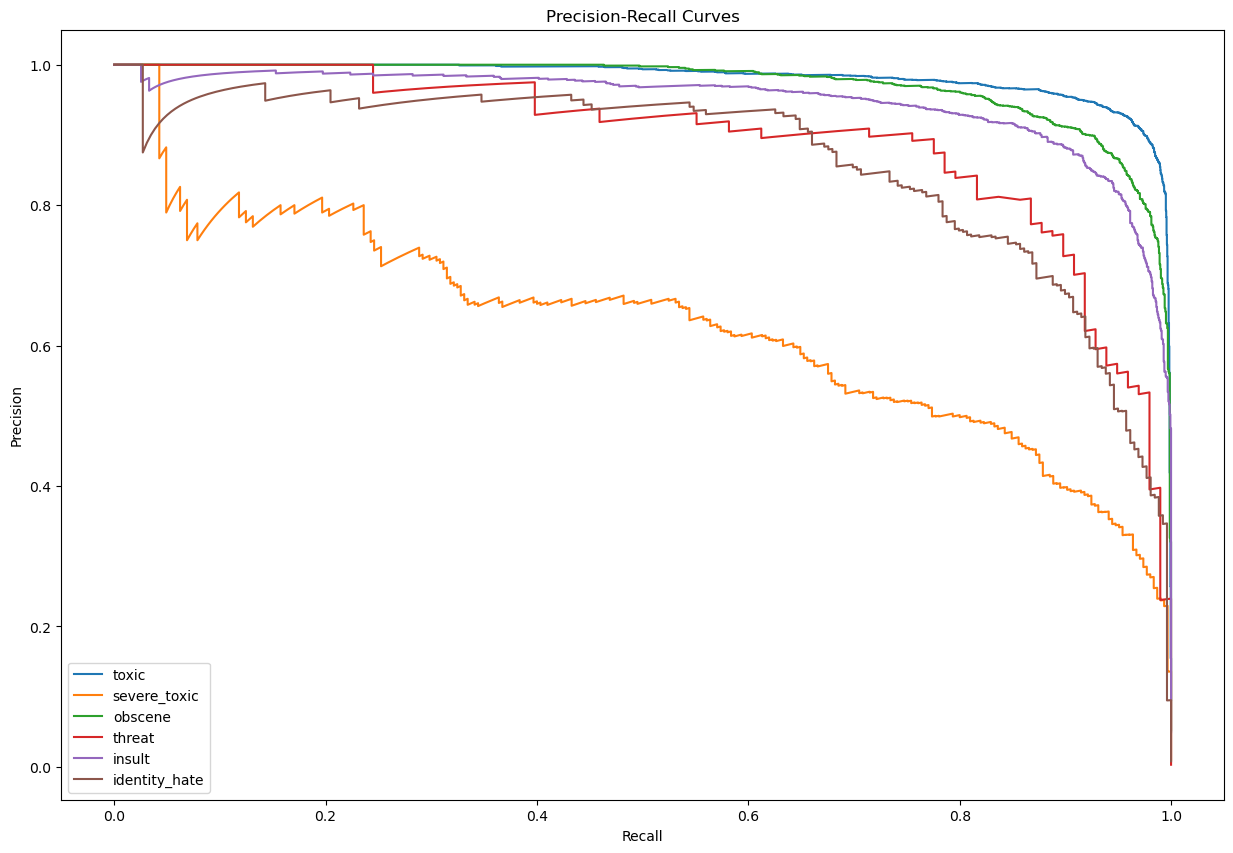

In [75]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
plot_precision_recall_curves(model, val_loader, class_names, threshold=0.5)

Analysis:

1. **Toxic (Blue Curve)**:
   - The precision-recall curve for the `toxic` class is quite strong. It stays close to the top left, indicating good precision and recall for this class. The model can maintain high precision even with very high recall, which suggests that it's performing well on this label.

2. **Severe Toxic (Orange Curve)**:
   - The `severe_toxic` class has a noticeable drop in both precision and recall as recall increases. This suggests that the model struggles more with distinguishing examples of this class. It's common for minority classes to have poorer performance in imbalanced datasets, which might be the case here.

3. **Obscene (Green Curve)**:
   - The `obscene` class performs well with a smooth curve and stays closer to the top-right. This indicates that the model is performing with high precision and recall, meaning it can effectively identify obscene content.

4. **Threat (Red Curve)**:
   - The curve for the `threat` class performs moderately well but starts to drop off earlier than other classes. It shows that the model may be able to classify threats at a moderate recall level but struggles when trying to capture all possible examples of threats.

5. **Insult (Purple Curve)**:
   - The precision-recall curve for `insult` is relatively good, but it slightly drops off as recall increases, indicating a bit more struggle when it tries to capture a higher number of insults while keeping precision high.

6. **Identity Hate (Brown Curve)**:
   - The `identity_hate` class has a steep drop, indicating difficulty in maintaining precision as recall increases. This suggests that the model struggles with this class, especially when trying to capture a larger portion of examples (high recall). 

Observations:
   - For most classes like `toxic`, `obscene`, and `insult`, the model performs quite well. However, for `severe_toxic`, `threat`, and `identity_hate`, the precision and recall trade-off is worse, showing that the model struggles with these minority or harder-to-classify classes.
   - These results suggest that the model still needs improvements for underrepresented classes like `severe_toxic` and `identity_hate`.

## 2. ROC Curves:

ROC curves show the trade-offs between sensitivity (recall) and specificity for each class.

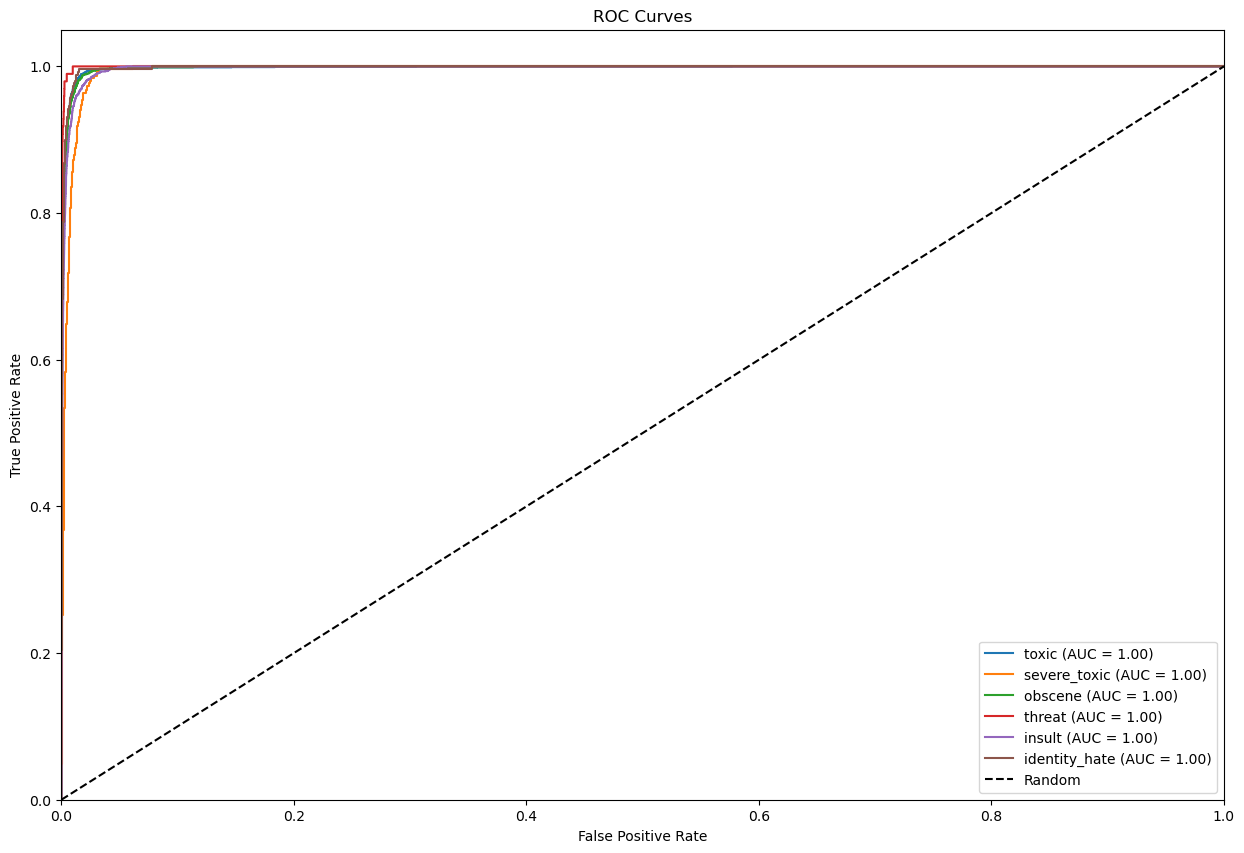

In [76]:
plot_roc_curves(model, val_loader, class_names, threshold=0.5)

Analysis:

   - The ROC curves show perfect AUC values for all classes, which is surprising and potentially indicative of overfitting or overly optimistic results on the validation data.
   - It's essential to ensure that the validation set is representative of the test distribution to avoid overly optimistic AUC scores.